# 1. Install Dependencies and Setup

In [1]:
!pip install albumentations

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/125.7 kB ? eta -:--:--
   ---------------------- ----------------- 71.7/125.7 kB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 125.7/125.7 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.0 MB 2.2 MB/s eta 0:00:18
   ---------------------------------------- 0.2/38.0 MB 1.8 MB/s eta 0:00:22
   ---------------------------------------- 0.2/38.0 MB 1.5 MB/s eta 0:00:25
   ---------------------------------------- 0.3/38.0 MB 1.5 MB/s eta 0:00:25
   ---------------------------------------- 0.4/38.0 MB 1.7 MB/s eta 0:00:23
    --------------------------------------- 0.5/38.0 MB 1.9 MB/s eta 0:00:21
    --------------------------------------- 0.7/38.0 MB 2.0 MB/s eta 0:00:19
    --------------------------------------- 0.8/38.0 MB 2.2 MB/s eta 0:00:18
    --

# 2. Collect Images

In [3]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
IMAGES_PATH = '../aug_data'
number_images = 80

In [ ]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# 3. Create Dataset

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [175]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [85]:
train_images = tf.data.Dataset.list_files('..\\aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250, 250)))
train_images = train_images.map(lambda x: x/255)

In [86]:
val_images = tf.data.Dataset.list_files('..\\aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250, 250)))
val_images = val_images.map(lambda x: x/255)

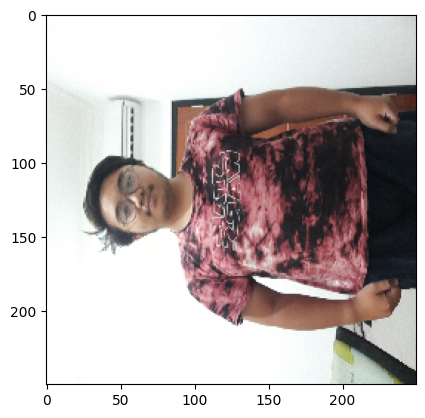

In [87]:
plt.imshow(train_images.as_numpy_iterator().next())

In [119]:
train_label = []

train_file_name = os.listdir('../aug_data/train/labels/')
for file in train_file_name:
    with open (os.path.join('../aug_data', 'train', 'labels', file), 'r', encoding = 'utf-8') as f:
        train_label.append(json.load(f))

In [120]:
train_keypoints = []
for i in train_label :
    Keypoints_x = []
    Keypoints_y = []
    for j in i['shapes']:
        Keypoints_x.append(j['points'][0][0] / 3456)
        Keypoints_y.append(j['points'][0][1] / 4608)
    
    train_keypoints.append([Keypoints_x, Keypoints_y])

In [113]:
train_keypoints[0]
          

[['bahu_kiri',
  'lengan_kiri',
  'tangan_kiri',
  'pinggul_kiri',
  'bahu_kanan',
  'lengan_kanan',
  'tangan_kanan',
  'pinggul_kanan'],
 [0.30963693957115007,
  0.18628167641325533,
  0.22435428849902536,
  0.29288499025341136,
  0.6477217348927875,
  0.764985380116959,
  0.7421418128654971,
  0.6583820662768031],
 [0.3697916666666667,
  0.6975968567251462,
  0.902046783625731,
  0.810672514619883,
  0.3812134502923976,
  0.7101608187134503,
  0.890625,
  0.8163834064327484]]

In [114]:
val_label = []

val_file_name = os.listdir('../aug_data/val/labels/')
for file in val_file_name:
    with open (os.path.join('../aug_data', 'val', 'labels', file), 'r', encoding = 'utf-8') as f:
        val_label.append(json.load(f))

In [121]:
val_keypoints = []
for i in val_label :
    Keypoints_name = []
    Keypoints_x = []
    Keypoints_y = []
    for j in i['shapes']:
        Keypoints_name.append(j['label'])
        Keypoints_x.append(j['points'][0][0] / 3456)
        Keypoints_y.append(j['points'][0][1] / 4608)
    
    val_keypoints.append([Keypoints_x, Keypoints_y])

In [122]:
val_keypoints[0]

[[0.4223318713450292,
  0.3735989278752437,
  0.37664473684210525,
  0.42690058479532156,
  0.5578703703703702,
  0.6172636452241717,
  0.6142178362573099,
  0.5502558479532162],
 [0.535407529239766,
  0.6633315058479532,
  0.7809758771929824,
  0.7113029970760233,
  0.534265350877193,
  0.6804641812865496,
  0.7752649853801169,
  0.7170138888888888]]

In [123]:
train_keypoints = tf.data.experimental.from_list(train_keypoints)

In [131]:
train_keypoints.take(1)

<_TakeDataset element_spec=TensorSpec(shape=(2, 8), dtype=tf.float32, name=None)>

In [124]:

train = tf.data.Dataset.zip((train_images, train_keypoints))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [125]:
val_keypoints = tf.data.experimental.from_list(val_keypoints)

In [126]:
val = tf.data.Dataset.zip((val_images, val_keypoints))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

In [159]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout, Dense
from tensorflow.keras.applications import ResNet152V2

In [160]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    # Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Dense(16),
    Reshape((2, 8))
])

In [137]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_13 (Conv2D)          (None, 2, 2, 256)         262400    
                                                                 
 dropout_2 (Dropout)         (None, 2, 2, 256)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 1, 4)          

In [140]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()

In [162]:
model.compile(optimizer, loss)

In [142]:
X, y = train.as_numpy_iterator().next()


In [143]:
scores = model.predict(X)

1/1 [==============================] - 6s 6s/step


In [145]:
scores

(16, 4)

In [163]:
hist = model.fit(train, epochs=50, validation_data=val)

Epoch 1/50


2/2 [==============================] - 85s 16s/step - loss: 25.2806 - val_loss: 0.7701
Epoch 2/50
2/2 [==============================] - 28s 10s/step - loss: 0.3870 - val_loss: 0.7003
Epoch 3/50
2/2 [==============================] - 27s 10s/step - loss: 0.2581 - val_loss: 2.6953
Epoch 4/50
2/2 [==============================] - 28s 11s/step - loss: 0.2463 - val_loss: 3.8984
Epoch 5/50
2/2 [==============================] - 29s 11s/step - loss: 0.2411 - val_loss: 5.8246
Epoch 6/50
2/2 [==============================] - 30s 11s/step - loss: 0.2386 - val_loss: 6.2445
Epoch 7/50
2/2 [==============================] - 28s 11s/step - loss: 0.2377 - val_loss: 9.0243
Epoch 8/50
2/2 [==============================] - 29s 11s/step - loss: 0.2378 - val_loss: 10.9725
Epoch 9/50
2/2 [==============================] - 28s 10s/step - loss: 0.2371 - val_loss: 18.0398
Epoch 10/50
2/2 [==============================] - 28s 11s/step - loss: 0.2351 - val_loss: 28.7960
Epoch 11/50
2/2 [===================

In [170]:
hist.history

{'loss': [25.2806396484375,
  0.3869742453098297,
  0.2581453323364258,
  0.2463327795267105,
  0.24109028279781342,
  0.2385626584291458,
  0.23765133321285248,
  0.2378082275390625,
  0.2370520830154419,
  0.23511536419391632,
  0.23388056457042694,
  0.230160653591156,
  0.22860604524612427,
  0.22800014913082123,
  0.22620034217834473,
  0.225410595536232,
  0.22559447586536407,
  0.2223590463399887,
  0.2215161919593811,
  0.21870560944080353,
  0.2178627848625183,
  0.21639621257781982,
  0.2146931141614914,
  0.21444560587406158,
  0.21207807958126068,
  0.21105070412158966,
  0.20901493728160858,
  0.208147332072258,
  0.2073855847120285,
  0.20628422498703003,
  0.2050008326768875,
  0.20304256677627563,
  0.20196382701396942,
  0.20097903907299042,
  0.20007507503032684,
  0.1989070624113083,
  0.19788771867752075,
  0.19641947746276855,
  0.19492359459400177,
  0.1941135674715042,
  0.1927739381790161,
  0.19148272275924683,
  0.19046153128147125,
  0.18940651416778564,
  0.

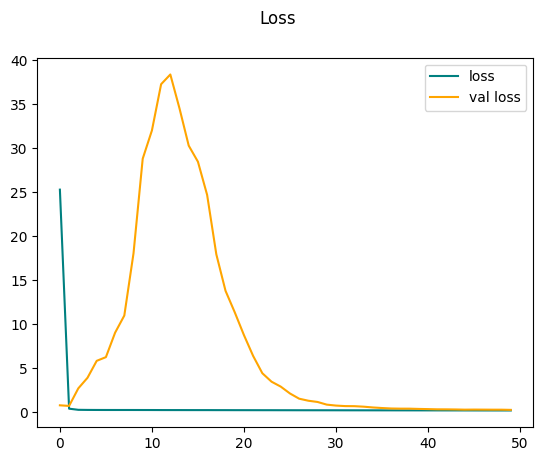

In [176]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

In [179]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500,50:500,:] 
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]
    
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

TypeError: 'NoneType' object is not subscriptable

In [185]:
val_data = val.as_numpy_iterator()

In [186]:
val_sample = val_data.next()

In [195]:
yhat = model.predict(val_sample[0])

1/1 [==============================] - 1s 1s/step


In [202]:
yhat[0][0][0]

0.6145494

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


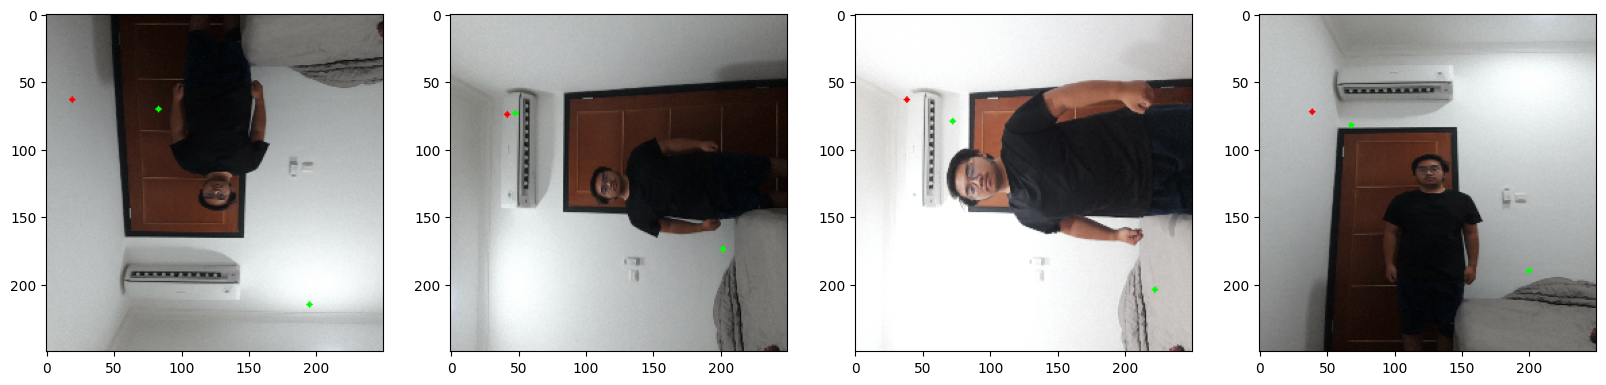

In [204]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = val_sample[0][idx]
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:, 0], [250, 250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:, 1], [250, 250]).astype(int)), 2, (0,255,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:, 2], [250, 250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:, 3], [250, 250]).astype(int)), 2, (0,255,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:, 4], [250, 250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:, 5], [250, 250]).astype(int)), 2, (0,255,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:, 6], [250, 250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:, 7], [250, 250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)